# Libraries

In [1]:
import os

# Print out the location/directory of this jupyter notebook file
notebook_path = os.getcwd()
print(notebook_path)

C:\Users\20245580\JupyterNotebookFiles


In [2]:
from brian2 import *
%matplotlib inline

In [3]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))

    # the left-hand side plot
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10) # 'ok': circle marker - black; ms: marker size
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k') # '-k': solid line - black
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))

    # The right-hand side plot
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

    # save
    savefig('NetworkConnections')
    show()

# References

[0] Understanding the homeostasis: Watt, A. J., & Desai, N. S. (2010). Homeostatic plasticity and STDP: keeping a neuron’s cool in a fluctuating world. Frontiers in Synaptic Neuroscience, 2. https://doi.org/10.3389/fnsyn.2010.00005

[1] Homeostasis code: https://brian2.readthedocs.io/en/latest/examples/frompapers.Clopath_et_al_2010_homeostasis.html 

[2] https://brian2.readthedocs.io/en/latest/examples/frompapers.Vogels_et_al_2011.html

[3] Homeostasis integrated in STDP biased towards LTD: Song S, Abbott LF. Cortical development and remapping through spike timing-dependent plasticity. Neuron. 2001 Oct 25;32(2):339-50. doi: 10.1016/s0896-6273(01)00451-2. PMID: 11684002.


# Experiment

## from [1], with comparison to my modification

In [ ]:
start_scope()
################################################################################
# PLASTICITY MODEL
################################################################################

#### Plasticity Parameters

V_rest = -70.*mV        # resting potential
V_thresh = -55.*mV      # spiking threshold
Theta_low = V_rest      # depolarization threshold for plasticity
x_reset = 1.            # spike trace reset value
taux = 15.*ms           # spike trace time constant
A_LTD = 1.5e-4          # depression amplitude
A_LTP = 1.5e-2          # potentiation amplitude
tau_lowpass1 = 40*ms    # timeconstant for low-pass filtered voltage
tau_lowpass2 = 30*ms    # timeconstant for low-pass filtered voltage
tau_homeo = 1000*ms     # homeostatic timeconstant
v_target = 12*mV**2     # target depolarisation

#### Plasticity Equations

# equations executed at every timestepC
Syn_model =   ('''
            w_ampa:1                # synaptic weight (ampa synapse)
            ''')

# equations executed only when a presynaptic spike occurs
Pre_eq = ('''
            g_ampa_post += w_ampa*ampa_max_cond                                                               # increment synaptic conductance
            A_LTD_u = A_LTD*(v_homeo**2/v_target)                                                             # metaplasticity
            w_minus = A_LTD_u*(v_lowpass1_post/mV - Theta_low/mV)*int(v_lowpass1_post/mV - Theta_low/mV > 0)  # synaptic depression
            w_ampa = clip(w_ampa-w_minus, 0, w_max)                                                           # hard bounds
            ''' )

# equations executed only when a postsynaptic spike occurs
Post_eq = ('''
            v_lowpass1 += 10*mV                                                                                        # mimics the depolarisation effect due to a spike
            v_lowpass2 += 10*mV                                                                                        # mimics the depolarisation effect due to a spike
            v_homeo += 0.1*mV                                                                                          # mimics the depolarisation effect due to a spike
            w_plus = A_LTP*x_trace_pre*(v_lowpass2_post/mV - Theta_low/mV)*int(v_lowpass2_post/mV - Theta_low/mV > 0)  # synaptic potentiation
            w_ampa = clip(w_ampa+w_plus, 0, w_max)                                                                     # hard bounds
            ''' )

# My equations executed at every timestepC
Syn_model_m =   ('''
            w_ampa:1                # synaptic weight (ampa synapse)
            dx_trace_prespike/dt = -x_trace_prespike/taux :1  (event-driven)
            ''')

# equations executed only when a presynaptic spike occurs
Pre_eq_m = ('''
            g_ampa_post += w_ampa*ampa_max_cond                                                               # increment synaptic conductance
            A_LTD_u = A_LTD*(v_homeo**2/v_target)                                                             # metaplasticity
            w_minus = A_LTD_u*(v_lowpass1_post/mV - Theta_low/mV)*int(v_lowpass1_post/mV - Theta_low/mV > 0)  # synaptic depression
            w_ampa = clip(w_ampa-w_minus, 0, w_max)                                                           # hard bounds
            x_trace_prespike+=x_reset/(taux/ms)
            ''' )

# equations executed only when a postsynaptic spike occurs
Post_eq_m = ('''
            v_lowpass1 += 10*mV                                                                                        # mimics the depolarisation effect due to a spike
            v_lowpass2 += 10*mV                                                                                        # mimics the depolarisation effect due to a spike
            v_homeo += 0.1*mV                                                                                          # mimics the depolarisation effect due to a spike
            w_plus = A_LTP*x_trace_prespike*(v_lowpass2_post/mV - Theta_low/mV)*int(v_lowpass2_post/mV - Theta_low/mV > 0)  # synaptic potentiation
            w_ampa = clip(w_ampa+w_plus, 0, w_max)                                                                     # hard bounds
            ''' )
################################################################################
# I&F Parameters and equations
################################################################################

#### Neuron parameters

gleak = 30.*nS                  # leak conductance
C = 300.*pF                     # membrane capacitance
tau_AMPA = 2.*ms                # AMPA synaptic timeconstant
E_AMPA = 0.*mV                  # reversal potential AMPA

ampa_max_cond = 5.e-8*siemens  # Ampa maximal conductance
w_max = 1.                      # maximal ampa weight

#### Neuron Equations

# We connect 10 presynaptic neurons to 1 downstream neuron

# downstream neuron
eqs_neurons = '''
dv/dt = (gleak*(V_rest-v) + I_ext + I_syn)/C: volt      # voltage
dv_lowpass1/dt = (v-v_lowpass1)/tau_lowpass1 : volt     # low-pass filter of the voltage
dv_lowpass2/dt = (v-v_lowpass2)/tau_lowpass2 : volt     # low-pass filter of the voltage
dv_homeo/dt = (v-V_rest-v_homeo)/tau_homeo : volt       # low-pass filter of the voltage
I_ext : amp                                             # external current
I_syn = g_ampa*(E_AMPA-v): amp                          # synaptic current
dg_ampa/dt = -g_ampa/tau_AMPA : siemens                 # synaptic conductance
dx_trace/dt = -x_trace/taux :1                          # spike trace
'''

# input neurons
eqs_inputs = '''
dv/dt = gleak*(V_rest-v)/C: volt                        # voltage
dx_trace/dt = -x_trace/taux :1                          # spike trace
rates : Hz                                              # input rates
selected_index : integer (shared)                       # active neuron
'''

################################################################################
# Simulation
################################################################################

#### Parameters

defaultclock.dt = 500.*us                        # timestep
Nr_neurons = 1                                   # Number of downstream neurons
Nr_inputs = 5                                    # Number of input neurons
input_rate = 35*Hz                               # Rates
init_weight = 0.5                                # initial synaptic weight
final_t = 20.*second                             # end of simulation
input_time = 100.*ms                             # duration of an input

#### Create neuron objects

Nrn_downstream = NeuronGroup(Nr_neurons*2, eqs_neurons, threshold='v>V_thresh',
                             reset='v=V_rest;x_trace+=x_reset/(taux/ms)',
                             method='euler')
Nrn_downstream_o = Nrn_downstream[:Nr_neurons]
Nrn_downstream_m = Nrn_downstream[Nr_neurons:]


Nrns_input = NeuronGroup(Nr_inputs, eqs_inputs, threshold='rand()<rates*dt',
                         reset='v=V_rest;x_trace+=x_reset/(taux/ms)',
                         method='exact')

#### create Synapses

Syn = Synapses(Nrns_input, Nrn_downstream_o,
               model=Syn_model,
               on_pre=Pre_eq,
               on_post=Post_eq
               )

Syn.connect(i=numpy.arange(Nr_inputs), j=0)

Syn_m = Synapses(Nrns_input, Nrn_downstream_m,
               model=Syn_model_m,
               on_pre=Pre_eq_m,
               on_post=Post_eq_m
               )

Syn_m.connect(i=numpy.arange(Nr_inputs), j=0)

#### Monitors and storage
W_evolution = StateMonitor(Syn, 'w_ampa', record=True)
W_evolution_m = StateMonitor(Syn_m, 'w_ampa', record=True)

#### Run

# Initial values
Nrn_downstream.v = V_rest
Nrn_downstream.v_lowpass1 = V_rest
Nrn_downstream.v_lowpass2 = V_rest
Nrn_downstream.v_homeo = 0
Nrn_downstream.I_ext = 0.*amp
Nrn_downstream.x_trace = 0.
Nrns_input.v = V_rest
Nrns_input.x_trace = 0.
Syn.w_ampa = init_weight

Syn_m.w_ampa = init_weight

# Switch on a different input every 100ms
Nrns_input.run_regularly('''
                         selected_index = int(floor(rand()*Nr_inputs))
                         rates = input_rate * int(selected_index == i)  # All rates are zero except for the selected neuron
                         ''', dt=input_time)
run(final_t, report='text')

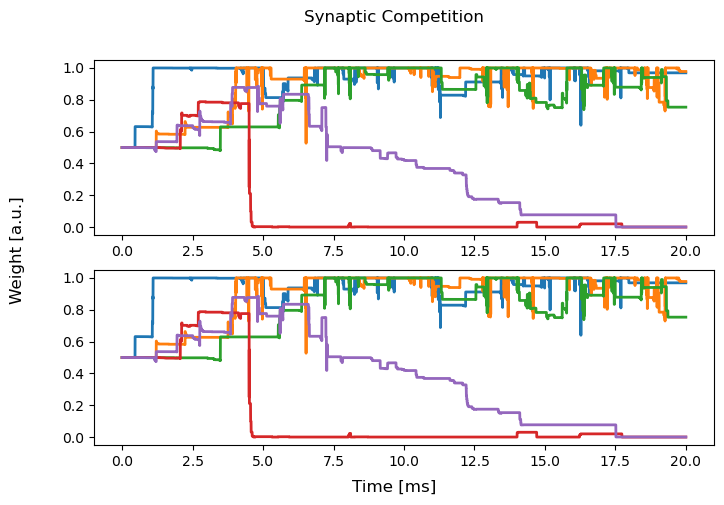

In [8]:
################################################################################
# Plots
################################################################################


fig, axs = plt.subplots(2, figsize=(8, 5)) #sharex=True, sharey=True
fig.suptitle('Synaptic Competition')

for kk in range(Nr_inputs):
    axs[0].plot(W_evolution.t, W_evolution.w_ampa[kk], '-', linewidth=2)
    axs[1].plot(W_evolution_m.t, W_evolution_m.w_ampa[kk], '-', linewidth=2)


fig.supxlabel('Time [ms]', fontsize=12)
fig.supylabel('Weight [a.u.]', fontsize=12)

#subplots_adjust(bottom=0.2, left=0.15, right=0.95, top=0.85)
#title(stitle, fontsize=22)
show()

## case 3: same as case 2, but combine and compare different parameters of stdp, neuron 

### Network

In [22]:
#### Neuron without/with adaptive threshold

start_scope()
defaultclock.dt = 500.*us 

# Poisson input group
N_INP = 20
inp_rates = np.ones(N_INP)* 3 * Hz
pg_inp = PoissonGroup(N_INP, inp_rates, name = 'inp') 


# Excictory group with adaptive threshold

############
##SUB GROUP REF:
##G = NeuronGroup(10, '''dv/dt = -v/tau : volt
##                       tau : second''',
##                threshold='v > -50*mV',
##                reset='v = -70*mV')
# Create subgroups
##G1 = G[:5]
##G2 = G[5:]

# This will set the values in the main group, subgroups are just "views"
##G1.tau = 10*ms
##G2.tau = 20*ms
############


N_NEURONS = 2

v_rest = 0
v_thresh_e = 24e-3
v_inh_base = 0
v_exc_base = 70e-3
v_reset= 10e-3

tau_ge = 5*ms
tau_gi = 5*ms
tau_mem = 50*ms
tc_theta= 1e7 * ms #1e7 * ms # 10 * ms # 1e7 * ms 

tau_lowpass1 = 40*ms    # timeconstant for low-pass filtered voltage
tau_lowpass2 = 30*ms    # timeconstant for low-pass filtered voltage
tau_homeo = 1000*ms     # homeostatic timeconstant

# Gaussian distribution - Brian2 : randn()
# Uniformaly distribution - Brian2 : rand()
refrac_mu, refrac_sigma = 5, 0.5 # mean and standard deviation
refractory = (5 + (refrac_mu + refrac_sigma*randn()))*ms # 5*ms

#sigma = 1.2 * (v_thresh_e - v_reset) # 0 # 1 * (v_thresh_e - v_reset)

eqs = '''
dv/dt = (v_rest-v + i_exc + i_inh)/tau_mem + sigma*xi*tau_mem**-0.5 : 1 (unless refractory)
i_exc = ge   * (v_exc_base -v)            : 1
i_inh = gi   * (v_inh_base - v)           : 1
dge/dt = -ge/ tau_ge                  : 1
dgi/dt = -gi/ tau_gi                  : 1
dtheta/dt = -theta / (tc_theta)         : 1
dtimer/dt = 0.1                           : second
sigma : 1

dv_lowpass1/dt = (v-v_lowpass1)/tau_lowpass1 : 1     # low-pass filter of the voltage
dv_lowpass2/dt = (v-v_lowpass2)/tau_lowpass2 : 1     # low-pass filter of the voltage
dv_homeo/dt = (v-v_rest-v_homeo)/tau_homeo : 1       # low-pass filter of the voltage
'''

# Excictory group with adaptive threshold
theta_plus_e_mu, theta_plus_ec_sigma = 0.05, 0.005 # mean and standard deviation
theta_plus_e = (0.05 + (theta_plus_e_mu + theta_plus_ec_sigma*randn()))* 1e-3 # 0.05e-3 #* mV # 0.05 * mV # an increased offset for neuron threshold after the neuron spikes.

reset = '''
v = v_reset
theta += theta_plus_e
timer = 0 * ms
'''


threshold_mu, threshold_sigma = v_thresh_e, (v_thresh_e/10)
# adpt, timer
threshold_adpt_timer = '(v>(theta + v_thresh_e + (threshold_mu + threshold_sigma*randn()))) and (timer>refractory)' # '(v>(theta + v_thresh_e)) and (timer>refractory)'
# adpt, no timer
threshold_adpt = 'v>(theta + v_thresh_e + (threshold_mu + threshold_sigma*randn()))'


ng_exc = NeuronGroup(
    N_NEURONS, eqs, 
    threshold= threshold_adpt_timer, 
    reset=reset, 
    refractory=refractory, 
    method='euler',
    name = 'exc')
ng_exc.sigma = 1.2 * (v_thresh_e - v_reset)

# Excictory group without adaptive threshold
reset_no_adthr = '''
v = v_reset
'''
ng_exc_no_adthr = NeuronGroup(
    N_NEURONS, eqs, 
    threshold= threshold_adpt, 
    reset=reset_no_adthr, 
    refractory=refractory, 
    method='euler',
    name = 'exc_no_adthr')
ng_exc_no_adthr.sigma = 1.2 * (v_thresh_e - v_reset)

# Excictory group with adaptive threshold, small nosie
ng_exc_sm_noise = NeuronGroup(
    N_NEURONS, eqs, 
    threshold= threshold_adpt_timer,
    reset=reset, 
    refractory=refractory, 
    method='euler',
    name = 'exc_sm_noise')
ng_exc_sm_noise.sigma = 0.5 * (v_thresh_e - v_reset)

# Excictory group without adaptive threshold, volt_stdp (vstdp)
ng_exc_no_adthr_vstdp = NeuronGroup(
    N_NEURONS, eqs, 
    threshold= threshold_adpt, 
    reset=reset_no_adthr, 
    refractory=refractory, 
    method='euler',
    name = 'exc_no_adthr_vstdp')
ng_exc_no_adthr_vstdp.sigma = 1.2 * (v_thresh_e - v_reset) # 0.5 * (v_thresh_e - v_reset)
ng_exc_no_adthr_vstdp.v_lowpass1 = v_rest
ng_exc_no_adthr_vstdp.v_lowpass2 = v_rest
ng_exc_no_adthr_vstdp.v_homeo = 0

# Excictory group adaptive threshold, volt_stdp (vstdp)
ng_exc_adthr_vstdp = NeuronGroup(
    N_NEURONS, eqs, 
    threshold= threshold_adpt, 
    reset=reset, 
    refractory=refractory, 
    method='euler',
    name = 'exc_adthr_vstdp')
ng_exc_adthr_vstdp.sigma = 1.2 * (v_thresh_e - v_reset) # 0.5 * (v_thresh_e - v_reset)
ng_exc_adthr_vstdp.v_lowpass1 = v_rest
ng_exc_adthr_vstdp.v_lowpass2 = v_rest
ng_exc_adthr_vstdp.v_homeo = 0


# Inhibitory Group group
v_thresh_i =  10
v_reset_i = 0

inh_eqs = '''
    v   : 1
'''

ng_inh = NeuronGroup(
            N_NEURONS * 5 * 5, inh_eqs,
            threshold = 'v > v_thresh_i',
            #refractory = 2 * ms,
            reset = 'v = v_reset_i',
            method = 'exact',
            name = 'inh')
ng_inh.v = 0

ng_inh_adthr = ng_inh[:N_NEURONS*5]
ng_inh_no_adthr = ng_inh[N_NEURONS*5:N_NEURONS*10]
ng_inh_adthr_sm_noise = ng_inh[N_NEURONS*10:N_NEURONS*15]
ng_inh_no_adthr_vstdp = ng_inh[N_NEURONS*15:N_NEURONS*20]
ng_inh_adthr_vstdp = ng_inh[N_NEURONS*20:]


##### Synapse Definition

## From input layer to excitory layer with adaptive threshold
n_minus = 1 # 0.005 #0.0001 # depression learning rate
n_plus = 1 # 0.5 #0.01 # potentiation learning rate
taupre =  20 *ms # 20 * ms 
taupost =  20 * ms # 20 *ms
Apre = 0.02 # 0.05 # 0.03 
Bff = 1.1 #1.05
Apost = -(Bff * Apre * taupre) / taupost

wmax = 10 #5 #2 #1

on_pre ='''
apre += Apre
w = clip(w+ n_minus*apost , 0, wmax)
ge_post += w
'''
on_post = '''
apost += Apost
w = clip(w+ n_plus*apre, 0, wmax)
'''

model = '''
w : 1
dapre/dt = -apre/taupre : 1 (clock-driven) 
dapost/dt = -apost/taupost : 1 (clock-driven)
'''

syns_inp_exc = Synapses(
        pg_inp, ng_exc,
        model = model,
        on_pre = on_pre,
        on_post = on_post,
        method='linear',
        name = 'inp_exc'
    )
syns_inp_exc.connect(True) # same as syns_inp_exc.connect()
#syns_inp_exc.delay = 'rand() * 10 * ms' 
# np.random.random(<output size>)
#numpy.random.seed(0) # CAUTION: using this random seed, 
                     # causing the Poisson process of BRAIN2 DOES NOT WORK anymore (no more randomness in the Poisson spike generation).
                     # Therefore, must comment out this ! before running any experiments   
#mu, sigma = 0.5, 0.1 # mean and standard deviation
#size_output = N_INP * N_NEURONS
#s = np.random.normal(mu, sigma,size_output)
#weights = s
weights = wmax/2 # 2.5 #1 # 0.5
syns_inp_exc.w = weights

## From input layer to excitory layer without adaptive threshold
syns_inp_exc_no_adthr = Synapses(
        pg_inp, ng_exc_no_adthr,
        model = model,
        on_pre = on_pre,
        on_post = on_post,
        method='linear',
        name = 'inp_exc_no_adthr'
    )
syns_inp_exc_no_adthr.connect(True) # same as syns_inp_exc.connect()  
syns_inp_exc_no_adthr.w = weights

## From input layer to excitory layer with adaptive threshold, small nosie
syns_inp_exc_adthr_sm_noise = Synapses(
        pg_inp, ng_exc_sm_noise,
        model = model,
        on_pre = on_pre,
        on_post = on_post,
        method='linear',
        name = 'inp_exc_no_adthr_sm_nosie'
    )
syns_inp_exc_adthr_sm_noise.connect(True) # same as syns_inp_exc.connect()  
syns_inp_exc_adthr_sm_noise.w = weights

## From input layer to excitory layer no adaptive threshold, volt-dependent stdp
taux = 15.*ms
ampa_max_cond = 1 #1 # 1
v_target = (12e-3)**2 # (should be relative to vhomeo)
A_LTD = 1.5e-5 # 1.5e-7 # 1.5e-4 # like the Apost in STDP synapse
A_LTP = 1e-3 #1.5e-2 # like the Apre in STDP synapse
Theta_low = v_rest
x_reset = 1

# My equations executed at every timestepC
Syn_model_m =   ('''
            w:1                # synaptic weight (ampa synapse)
            #x_trace_prespike:1
            dx_trace_prespike/dt = -x_trace_prespike/taux :1  (event-driven)
            ''')

# equations executed only when a presynaptic spike occurs
Pre_eq_m = ('''
            ge_post += w*ampa_max_cond                                                               # increment synaptic conductance
            A_LTD_u = A_LTD*(v_homeo**2/v_target)                                                             # metaplasticity
            w_minus = A_LTD_u*(v_lowpass1_post/(1e-3) - Theta_low/(1e-3))*int(v_lowpass1_post/(1e-3) - Theta_low/(1e-3) > 0)  # synaptic depression
            w = clip(w - w_minus, 0, wmax)                                                           # hard bounds
            x_trace_prespike+=x_reset/(taux/ms)
            ''' )

# equations executed only when a postsynaptic spike occurs
Post_eq_m = ('''
            v_lowpass1 += 10e-3                                                                                        # mimics the depolarisation effect due to a spike
            v_lowpass2 += 10e-3                                                                                        # mimics the depolarisation effect due to a spike
            v_homeo += 0.1e-3                                                                                          # mimics the depolarisation effect due to a spike
            w_plus = A_LTP*x_trace_prespike*(v_lowpass2_post/(1e-3) - Theta_low/(1e-3))*int(v_lowpass2_post/(1e-3) - Theta_low/(1e-3) > 0)  # synaptic potentiation
            w = clip(w + w_plus, 0, wmax)                                                                     # hard bounds
            ''' )

syns_inp_exc_no_adthr_vstdp = Synapses(
        pg_inp, ng_exc_no_adthr_vstdp,
        model = Syn_model_m,
        on_pre = Pre_eq_m,
        on_post = Post_eq_m,
        method='linear',
        name = 'inp_exc_no_adthr_vstdp'
    )
syns_inp_exc_no_adthr_vstdp.connect(True) # same as syns_inp_exc.connect()  
syns_inp_exc_no_adthr_vstdp.w = weights
syns_inp_exc_no_adthr_vstdp.x_trace_prespike = 0

## From input layer to excitory layer adaptive threshold, volt-dependent stdp
syns_inp_exc_adthr_vstdp = Synapses(
        pg_inp, ng_exc_adthr_vstdp,
        model = Syn_model_m,
        on_pre = Pre_eq_m,
        on_post = Post_eq_m,
        method='linear',
        name = 'inp_exc_adthr_vstdp'
    )
syns_inp_exc_adthr_vstdp.connect(True) # same as syns_inp_exc.connect()  
syns_inp_exc_adthr_vstdp.w = weights
syns_inp_exc_adthr_vstdp.x_trace_prespike = 0

## From excitory layer to inhibitory layer
W_EXC_INH = 17.0 # > v_thresh_i 
syns_exc_inh = Synapses(ng_exc, ng_inh_adthr,
                            on_pre = 'v_post += W_EXC_INH')
#syns_exc_inh.connect(j = 'i')
syns_exc_inh.connect(True)

syns_exc_inh_no_adthr = Synapses(ng_exc_no_adthr, ng_inh_no_adthr,
                            on_pre = 'v_post += W_EXC_INH')
#syns_exc_inh_no_adthr.connect(j = 'i')
syns_exc_inh_no_adthr.connect(True)

syns_exc_inh_adthr_sm_noise = Synapses(ng_exc_sm_noise, ng_inh_adthr_sm_noise,
                            on_pre = 'v_post += W_EXC_INH')
syns_exc_inh_adthr_sm_noise.connect(True)

syns_exc_inh_no_adthr_vstdp = Synapses(ng_exc_no_adthr_vstdp, ng_inh_no_adthr_vstdp,
                            on_pre = 'v_post += W_EXC_INH')
syns_exc_inh_no_adthr_vstdp.connect(True)

syns_exc_inh_adthr_vstdp = Synapses(ng_exc_adthr_vstdp, ng_inh_adthr_vstdp,
                            on_pre = 'v_post += W_EXC_INH')
syns_exc_inh_adthr_vstdp.connect(True)

## From inhibitory layer to excitory layer
W_INH_EXC = 0.01*wmax # 0.01*wmax (Good for few epochs but for much more epochs, still BAD ) # 0.5*wmax (BAD -> cause neuron domination) #0.05*wmax
syns_inh_exc = Synapses(ng_inh_adthr, ng_exc,
                            on_pre = 'gi_post += W_INH_EXC')
syns_inh_exc.connect(condition='i!=j')

syns_inh_exc_no_adthr = Synapses(ng_inh_no_adthr, ng_exc_no_adthr,
                            on_pre = 'gi_post += W_INH_EXC')
syns_inh_exc_no_adthr.connect(condition='i!=j')

syns_inh_exc_adthr_sm_noise = Synapses(ng_inh_adthr_sm_noise, ng_exc_sm_noise,
                            on_pre = 'gi_post += W_INH_EXC')
syns_inh_exc_adthr_sm_noise.connect(condition='i!=j')

syns_inh_exc_no_adthr_vstdp = Synapses(ng_inh_no_adthr_vstdp, ng_exc_no_adthr_vstdp,
                            on_pre = 'gi_post += W_INH_EXC')
syns_inh_exc_no_adthr_vstdp.connect(condition='i!=j')

syns_inh_exc_adthr_vstdp = Synapses(ng_inh_adthr_vstdp, ng_exc_adthr_vstdp,
                            on_pre = 'gi_post += W_INH_EXC')
syns_inh_exc_adthr_vstdp.connect(condition='i!=j')

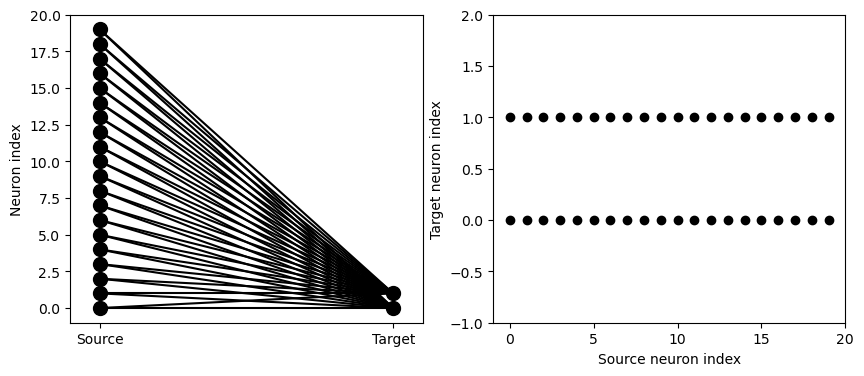

In [5]:
visualise_connectivity(syns_inp_exc)

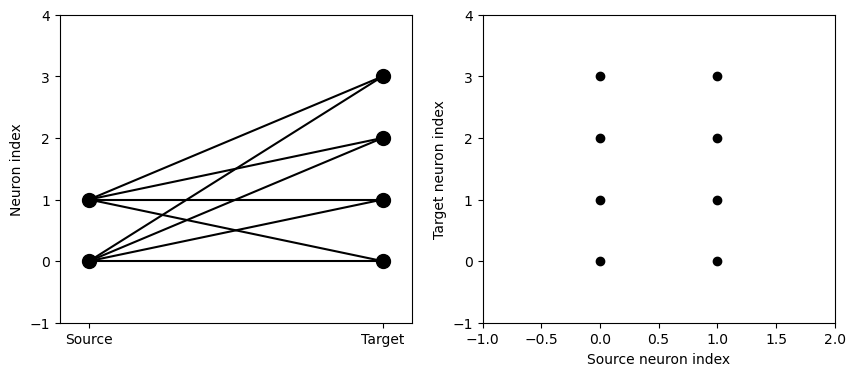

In [294]:
visualise_connectivity(syns_exc_inh) 

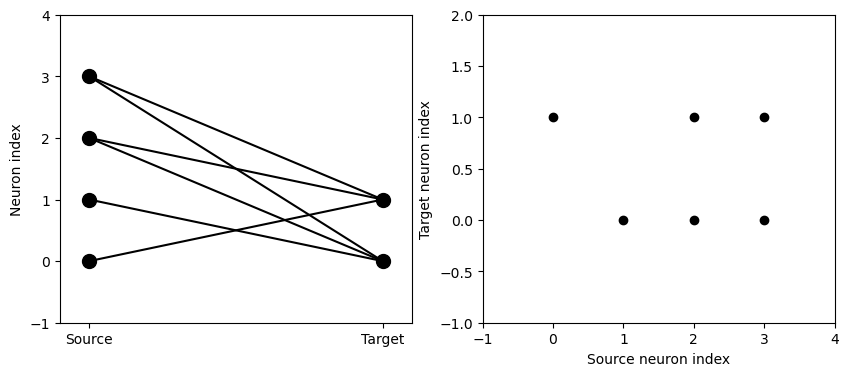

In [295]:
visualise_connectivity(syns_inh_exc) 

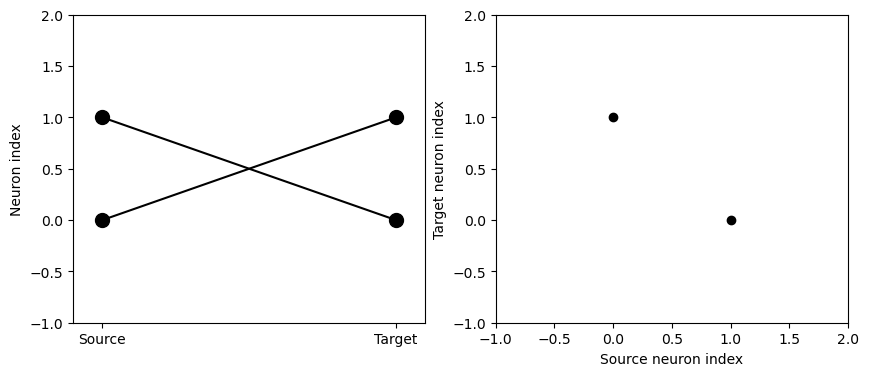

In [8]:
visualise_connectivity(syns_inh_exc_adthr_sm_noise) 

### Recording + net setup

In [23]:
# Recording 
syns_inp_exc_mon = StateMonitor(syns_inp_exc,  ['w', 'apre', 'apost', 'i', 'j'], record=True)
syns_inp_exc_no_adthr_mon = StateMonitor(syns_inp_exc_no_adthr,  ['w', 'apre', 'apost', 'i', 'j'], record=True)
syns_inp_exc_adthr_sm_noise_mon = StateMonitor(syns_inp_exc_adthr_sm_noise,  ['w', 'apre', 'apost', 'i', 'j'], record=True)
syns_inp_exc_no_adthr_vstdp_mon = StateMonitor(syns_inp_exc_no_adthr_vstdp,  ['w', 'x_trace_prespike', 'i', 'j'], record=True)
syns_inp_exc_adthr_vstdp_mon = StateMonitor(syns_inp_exc_adthr_vstdp,  ['w', 'x_trace_prespike', 'i', 'j'], record=True)
#syns_exc_exc_mon = StateMonitor(syns_exc_exc,  ['w', 'apre', 'apost', 'i', 'j'], record=True)
#syns_inh_exc_mon = StateMonitor(syns_inh_exc,  ['w', 'apre', 'apost'], record=True)

ng_exc_mon = StateMonitor(ng_exc,  ['v', 'theta', 'ge', 'gi'], record=True)
ng_exc_no_adthr_mon = StateMonitor(ng_exc_no_adthr,  ['v', 'theta', 'ge', 'gi'], record=True)
ng_exc_sm_noise_mon = StateMonitor(ng_exc_sm_noise,  ['v', 'theta', 'ge', 'gi'], record=True)
ng_exc_no_adthr_vstdp_mon = StateMonitor(ng_exc_no_adthr_vstdp,  ['v', 'theta', 'ge', 'gi', 'v_lowpass1', 'v_lowpass2', 'v_homeo'], record=True)
ng_exc_adthr_vstdp_mon = StateMonitor(ng_exc_adthr_vstdp,  ['v', 'theta', 'ge', 'gi', 'v_lowpass1', 'v_lowpass2', 'v_homeo'], record=True)

ng_exc_spikemon = SpikeMonitor(ng_exc)
ng_exc_no_adthr_spikemon = SpikeMonitor(ng_exc_no_adthr)
ng_exc_sm_noise_spikemon = SpikeMonitor(ng_exc_sm_noise)
ng_exc_no_adthr_vstdp_spikemon = SpikeMonitor(ng_exc_no_adthr_vstdp)
ng_exc_adthr_vstdp_spikemon = SpikeMonitor(ng_exc_adthr_vstdp)

ng_inp_spikemon = SpikeMonitor(pg_inp)

net = Network([pg_inp, ng_exc, ng_exc_no_adthr, ng_exc_sm_noise, ng_exc_no_adthr_vstdp, ng_exc_adthr_vstdp,
               ng_inh, #ng_inh_adthr, ng_inh_no_adthr, #pg_noise,
               syns_inp_exc, syns_exc_inh, syns_inh_exc, 
               syns_inp_exc_no_adthr, syns_exc_inh_no_adthr, syns_inh_exc_no_adthr, 
               syns_inp_exc_adthr_sm_noise, syns_exc_inh_adthr_sm_noise, syns_inh_exc_adthr_sm_noise, 
               syns_inp_exc_no_adthr_vstdp, syns_exc_inh_no_adthr_vstdp, syns_inh_exc_no_adthr_vstdp,
               syns_inp_exc_adthr_vstdp, syns_exc_inh_adthr_vstdp, syns_inh_exc_adthr_vstdp,
               syns_inp_exc_mon, ng_exc_mon, #syns_exc_exc_mon, 
               syns_inp_exc_no_adthr_mon, ng_exc_no_adthr_mon,
               syns_inp_exc_adthr_sm_noise_mon, ng_exc_sm_noise_mon,
               syns_inp_exc_no_adthr_vstdp_mon, ng_exc_no_adthr_vstdp_mon,
               syns_inp_exc_adthr_vstdp_mon, ng_exc_adthr_vstdp_mon,
               ng_exc_spikemon, ng_exc_no_adthr_spikemon, ng_exc_sm_noise_spikemon, ng_exc_no_adthr_vstdp_spikemon, ng_exc_adthr_vstdp_spikemon,
               ng_inp_spikemon])

net.run(0*second)

### Run

**Note**: 

[1] with inhbition weight small (0.01 * wmax) + small train_duration (100 ms) + no resting, wmax =2 , the competition among the adaptive threshold neuron (with / without timer) for different types of  syanpse model seems to be more effective for short training epoch. However if the training keeps going, the network again gets struck to one neuron domination over all inputs.

[2] with inhbition weight small (0.01 * wmax) + small train_duration (100 ms) + resting 10 ms, wmax = 2. For a lot of epochs, the functional model: 

    2.1 depression factor 1.1 STDP, neuron with adaptive threshold + timer, big noise

    2.2 volt STDP, neuron with adaptive threshold, small noise. But when the epoch keeps increasing further, the network becomes BAB. On the other hand, the model: depression factor 1.1 STDP, neuron with adaptive threshold + timer, small noise: starts to show good behavior.


[3] with inhbition weight small (0.01 * wmax) + small train_duration (100 ms) + resting 10 ms, wmax = 2, refractory = (5 + rand())*ms. For a lot of epochs, the functional model

    3.1 NONE


[4] with random offset threshold, threshold, refractory, the model with small noise can not spike -> no good for them. the model with adapt, timer, big noise gives good response. 

    4.1 NONE

[5] Conds: wmax = 10; A_LTD = 1.5e-7  # like the Apost in STDP synapse; A_LTP = 1e-3  # like the Apre in STDP synapse; 5 inhibit neurons per 2 output neurons, rest = 100 ms, train = 200 ms. The best condidate:

    5.1 The model without adaptive threshold, volt_stdp (vstdp)


[6] Conds: same as [5], except: A_LTD = 1.5e-4 ; A_LTP = 1e-3  + noise of volt-stdp is changed from 0.5 to 1.2; for long run only
    
    6.1 The model with adaptive threshold, depressed stdp (very random!!!) big noise

    6.2 The model without/with adaptive threshold, volt_stdp (vstdp)




In [24]:
rest_duration = 100 * ms # 50 * ms # 0 * ms
rest_freq = 0.5 # [Hz]
train_duration = 200 * ms # 100 * ms #  500 * ms



#inp_rates_0 = [6, 2, 2 , 2, 2, 2, 2, 2, 2 , 2,
#                2, 2, 2 , 2, 2, 2, 2, 2, 2 , 2 ] * Hz 

inp_rates_0 = [6, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 0.5,
                0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 0.5 ] * Hz 

#inp_rates_0 = [20, 10, 9 , 8, 7, 6, 5, 4, 3, 2 ,
#                1, 0, 0 , 0, 0, 0, 0, 0, 0 , 0 ] * Hz 


inp_rates_1 = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 0.5,
                0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5 , 6 ] * Hz 

#inp_rates_1 = [2, 2, 2 , 2, 2, 2, 2, 2, 2 , 2,
#                2, 2, 2 , 2, 2, 2, 2, 2, 2 , 6 ] * Hz

#inp_rates_1 = [0, 0, 0 , 0, 0, 0, 0, 0, 0 , 1,
#                 2, 3, 4, 5 , 6, 7, 8, 9, 10 , 20 ] * Hz

In [49]:
epoch = 100
for i in range(epoch):
    print(f"step: {i+1}")

    # Train
    net['inp'].rates = inp_rates_0
    net.run(train_duration)

    #rest
    net['inp'].rates = np.ones(N_INP)* rest_freq * Hz
    net.run(rest_duration)

    # Train
    net['inp'].rates = inp_rates_1
    net.run(train_duration)

    #rest
    net['inp'].rates = np.ones(N_INP) * rest_freq * Hz
    net.run(rest_duration)

print("Done")

step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15
step: 16
step: 17
step: 18
step: 19
step: 20
step: 21
step: 22
step: 23
step: 24
step: 25
step: 26
step: 27
step: 28
step: 29
step: 30
step: 31
step: 32
step: 33
step: 34
step: 35
step: 36
step: 37
step: 38
step: 39
step: 40
step: 41
step: 42
step: 43
step: 44
step: 45
step: 46
step: 47
step: 48
step: 49
step: 50
step: 51
step: 52
step: 53
step: 54
step: 55
step: 56
step: 57
step: 58
step: 59
step: 60
step: 61
step: 62
step: 63
step: 64
step: 65
step: 66
step: 67
step: 68
step: 69
step: 70
step: 71
step: 72
step: 73
step: 74
step: 75
step: 76
step: 77
step: 78
step: 79
step: 80
step: 81
step: 82
step: 83
step: 84
step: 85
step: 86
step: 87
step: 88
step: 89
step: 90
step: 91
step: 92
step: 93
step: 94
step: 95
step: 96
step: 97
step: 98
step: 99
step: 100
Done


In [431]:
net['inp'].rates = np.ones(N_INP) * rest_freq * Hz
net.run(5*rest_duration)

In [422]:
net['inp'].rates = inp_rates_0
net.run(500*ms)

#rest
net['inp'].rates = np.ones(N_INP)* Hz
net.run(5*second)

In [434]:
net['inp'].rates = inp_rates_1
net.run(500*ms)

#rest
net['inp'].rates = np.ones(N_INP) * Hz
net.run(5*second)

### Plot

In [38]:
print(ng_exc_mon.t[-1:]/ms, ng_exc_no_adthr_vstdp_mon.t[-1:]/ms)

[119999.5] [119999.5]


In [72]:
print(shape(ng_exc_spikemon.i), shape(ng_exc_no_adthr_spikemon.i))

(150,) (188,)


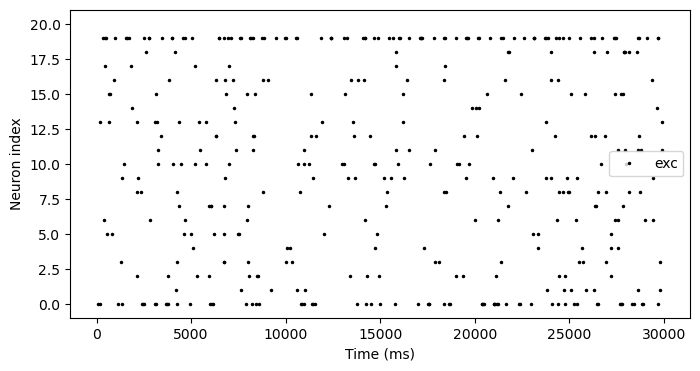

In [10]:
start = 0

figure(figsize=(8, 4)) #sharex=True, sharey=True,
neuron_index_num = N_INP # max(N_NEURONS, N_INP) # N_INP # max(N_NEURONS, N_INP)

plot(ng_inp_spikemon.t[start:]/ms, ng_inp_spikemon.i[start:], '.k', ms=3, label ='exc')
ylim(-1, neuron_index_num+1)
xlabel('Time (ms)')
ylabel('Neuron index')
legend()
show()

In [435]:
print(len(ng_exc_no_adthr_vstdp_spikemon.t))

168


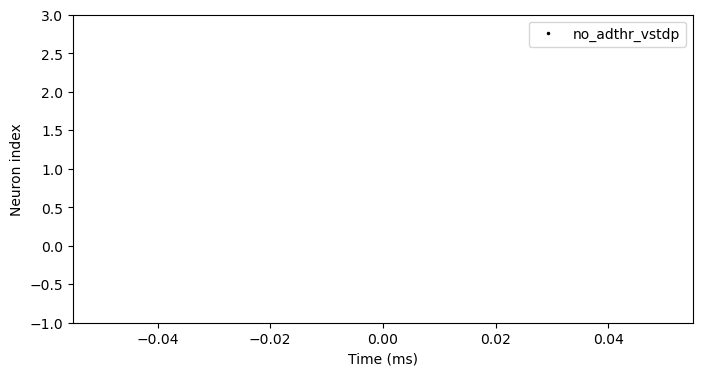

In [491]:
start = 0

figure(figsize=(8, 4)) #sharex=True, sharey=True,
neuron_index_num = N_NEURONS # max(N_NEURONS, N_INP) # N_INP # max(N_NEURONS, N_INP)

plot(ng_exc_no_adthr_vstdp_spikemon.t[start:]/ms, ng_exc_no_adthr_vstdp_spikemon.i[start:], '.k', ms=3, label ='no_adthr_vstdp')
ylim(-1, neuron_index_num+1)
xlabel('Time (ms)')
ylabel('Neuron index')
legend()
show()

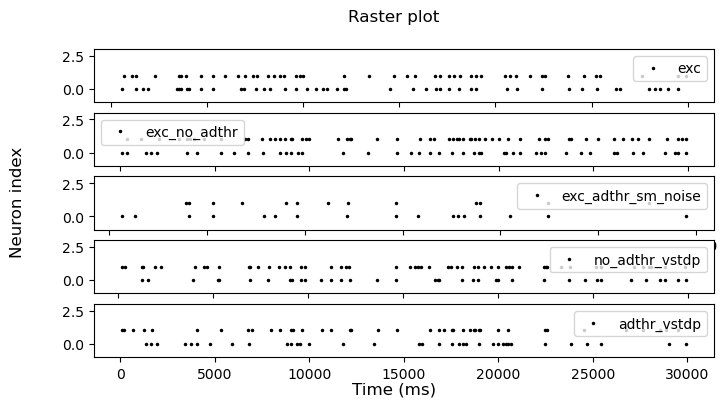

In [492]:
## Referece:
## [1] https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots
## [2] https://stackoverflow.com/questions/15858192/how-to-set-xlim-and-ylim-for-a-subplot

start = 0

fig, axs = plt.subplots(5,  figsize=(8, 4)) #sharex=True, sharey=True,
fig.suptitle('Raster plot')
#plot(ng_input_spikemon.t/ms, ng_input_spikemon.i, '.r', ms=3, label = 'inp')
neuron_index_num = N_NEURONS # max(N_NEURONS, N_INP) # N_INP # max(N_NEURONS, N_INP)

axs[0].plot(ng_exc_spikemon.t[start:]/ms, ng_exc_spikemon.i[start:], '.k', ms=3, label ='exc')
axs[0].set_ylim(-1, neuron_index_num+1)
axs[0].legend()

axs[1].plot(ng_exc_no_adthr_spikemon.t[start:]/ms, ng_exc_no_adthr_spikemon.i[start:], '.k', ms=3, label ='exc_no_adthr')
axs[1].set_ylim(-1, neuron_index_num+1)
axs[1].legend()

axs[2].plot(ng_exc_sm_noise_spikemon.t[start:]/ms, ng_exc_sm_noise_spikemon.i[start:], '.k', ms=3, label ='exc_adthr_sm_noise')
axs[2].set_ylim(-1, neuron_index_num+1)
axs[2].legend()

axs[3].plot(ng_exc_no_adthr_vstdp_spikemon.t[start:]/ms, ng_exc_no_adthr_vstdp_spikemon.i[start:], '.k', ms=3, label ='no_adthr_vstdp')
axs[3].set_ylim(-1, neuron_index_num+1)
axs[3].legend()

axs[4].plot(ng_exc_adthr_vstdp_spikemon.t[start:]/ms, ng_exc_adthr_vstdp_spikemon.i[start:], '.k', ms=3, label ='adthr_vstdp')
axs[4].set_ylim(-1, neuron_index_num+1)
axs[4].legend()

fig.supxlabel('Time (ms)')
fig.supylabel('Neuron index')

#legend()

show()

WARNING    C:\Users\20245580\AppData\Local\Temp\ipykernel_23744\4109914984.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
 [py.warnings]
WARNING    C:\Users\20245580\AppData\Local\Temp\ipykernel_23744\4109914984.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
 [py.warnings]
WARNING    C:\Users\20245580\AppData\Local\Temp\ipykernel_23744\4109914984.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[3].legend()
 [py.warnings]
WARNING    C:\Users\20245580\AppData\Local\Temp\ipykernel_23744\4109914984.py:27: UserWarning: No artists with labels found to put in legend.  No

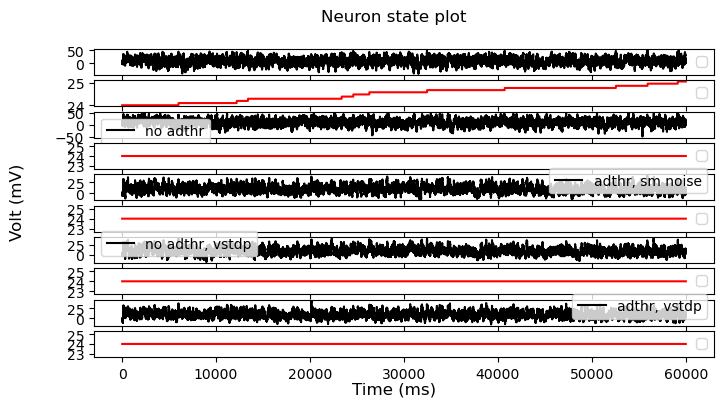

In [31]:

start = 0

fig, axs = plt.subplots(10, figsize=(8, 4)) #sharex=True,
fig.suptitle('Neuron state plot')
#plot(ng_input_spikemon.t/ms, ng_input_spikemon.i, '.r', ms=3, label = 'inp')
neuron_index_num = N_NEURONS # max(N_NEURONS, N_INP) # N_INP # max(N_NEURONS, N_INP)

axs[0].plot(ng_exc_mon.t/ms, ng_exc_mon.v[0]/mV, '-k')
#axs[0].plot(ng_exc_mon.t/ms, (ng_exc_mon.theta[0]+v_thresh_e)/mV, '-r')
axs[0].legend()

axs[1].plot(ng_exc_mon.t/ms, (ng_exc_mon.theta[0]+v_thresh_e)/mV, '-r')
axs[1].legend()

axs[2].plot(ng_exc_no_adthr_mon.t/ms, ng_exc_no_adthr_mon.v[0]/mV, '-k', label = 'no adthr')
#axs[2].plot(ng_exc_no_adthr_mon.t/ms, (ng_exc_no_adthr_mon.theta[0]+v_thresh_e)/mV, '-r')
axs[2].legend()

axs[3].plot(ng_exc_no_adthr_mon.t/ms, (ng_exc_no_adthr_mon.theta[0]+v_thresh_e)/mV, '-r')
axs[3].legend()

axs[4].plot(ng_exc_sm_noise_mon.t/ms, ng_exc_sm_noise_mon.v[0]/mV, '-k', label = 'adthr, sm noise')
#axs[2].plot(ng_exc_no_adthr_mon.t/ms, (ng_exc_no_adthr_mon.theta[0]+v_thresh_e)/mV, '-r')
axs[4].legend()

axs[5].plot(ng_exc_sm_noise_mon.t/ms, (ng_exc_sm_noise_mon.theta[0]+v_thresh_e)/mV, '-r')
axs[5].legend()

axs[6].plot(ng_exc_no_adthr_vstdp_mon.t/ms, ng_exc_no_adthr_vstdp_mon.v[0]/mV, '-k', label = 'no adthr, vstdp')
#axs[2].plot(ng_exc_no_adthr_mon.t/ms, (ng_exc_no_adthr_mon.theta[0]+v_thresh_e)/mV, '-r')
axs[6].legend()

axs[7].plot(ng_exc_no_adthr_vstdp_mon.t/ms, (ng_exc_no_adthr_vstdp_mon.theta[0]+v_thresh_e)/mV, '-r')
axs[7].legend()

axs[8].plot(ng_exc_adthr_vstdp_mon.t/ms, ng_exc_adthr_vstdp_mon.v[0]/mV, '-k', label = 'adthr, vstdp')
axs[8].legend()

axs[9].plot(ng_exc_adthr_vstdp_mon.t/ms, (ng_exc_adthr_vstdp_mon.theta[0]+v_thresh_e)/mV, '-r')
axs[9].legend()


fig.supxlabel('Time (ms)')
fig.supylabel('Volt (mV)')

#legend()

show()

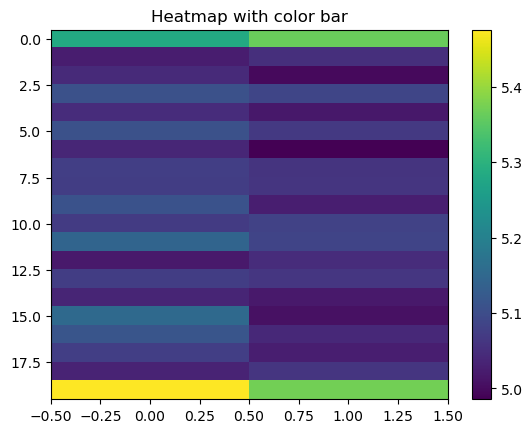

In [39]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_inp_exc = np.full((len(pg_inp), len(ng_exc)), np.nan)
# Insert the values from the Synapses object
W_inp_exc[syns_inp_exc_mon.i[:,-1], syns_inp_exc_mon.j[:,-1]] = syns_inp_exc_mon.w[:, -1]
#W = syns_inp_exc_mon.w[:, 200000-1]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
imshow(W_inp_exc, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
colorbar() 

show()

In [40]:
print(W_inp_exc)

[[5.28312568 5.36477989]
 [5.02429372 5.05097024]
 [5.04428042 4.9980949 ]
 [5.10693311 5.08779632]
 [5.04685686 5.01768529]
 [5.10763147 5.06760267]
 [5.03818182 4.98551742]
 [5.07724591 5.0589426 ]
 [5.07466723 5.06107302]
 [5.10848018 5.02597623]
 [5.07081428 5.08217765]
 [5.14334928 5.08646359]
 [5.01967932 5.04785505]
 [5.0755054  5.06395979]
 [5.03699704 5.01815952]
 [5.15314671 5.00738807]
 [5.11440804 5.04249914]
 [5.07590885 5.02651465]
 [5.03453778 5.06083474]
 [5.47596624 5.37090577]]


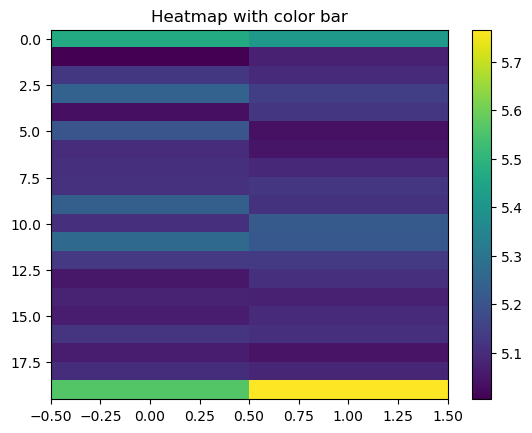

In [41]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_inp_exc_no_adthr = np.full((len(pg_inp), len(ng_exc_no_adthr)), np.nan)
# Insert the values from the Synapses object
W_inp_exc_no_adthr[syns_inp_exc_no_adthr_mon.i[:,-1:], syns_inp_exc_no_adthr_mon.j[:,-1:]] = syns_inp_exc_no_adthr_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
imshow(W_inp_exc_no_adthr, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
colorbar() 

show()

In [42]:
print(W_inp_exc_no_adthr)

[[5.47058514 5.41457023]
 [5.00411117 5.07518643]
 [5.12816897 5.09764982]
 [5.24434547 5.14639273]
 [5.03650672 5.1259208 ]
 [5.20388617 5.03943156]
 [5.10009316 5.04784657]
 [5.10904271 5.09107136]
 [5.11245939 5.12419595]
 [5.23597433 5.11719365]
 [5.10880807 5.21923205]
 [5.26465025 5.21498589]
 [5.13022807 5.13287894]
 [5.05256211 5.11027982]
 [5.07758944 5.07374212]
 [5.06360897 5.09865704]
 [5.12218791 5.10976017]
 [5.06298993 5.04544502]
 [5.10398967 5.08628992]
 [5.56158072 5.7663433 ]]


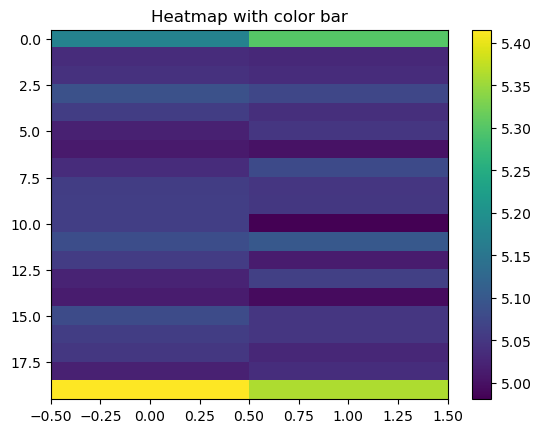

In [43]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_inp_exc_adthr_sm_nosie = np.full((len(pg_inp), len(ng_exc_sm_noise)), np.nan)
# Insert the values from the Synapses object
W_inp_exc_adthr_sm_nosie[syns_inp_exc_adthr_sm_noise_mon.i[:,-1:], syns_inp_exc_adthr_sm_noise_mon.j[:,-1:]] = syns_inp_exc_adthr_sm_noise_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
imshow(W_inp_exc_adthr_sm_nosie, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
colorbar() 

show()

In [44]:
print(W_inp_exc_adthr_sm_nosie)

[[5.17427954 5.30140449]
 [5.03666983 5.03085957]
 [5.0426871  5.03560577]
 [5.08847592 5.0728973 ]
 [5.05985183 5.03937276]
 [5.02032542 5.049407  ]
 [5.01132593 5.00203542]
 [5.035401   5.07909805]
 [5.06014415 5.05008674]
 [5.06115705 5.05185415]
 [5.06156878 4.9806958 ]
 [5.08382161 5.10106043]
 [5.05837046 5.01442468]
 [5.02401336 5.06230139]
 [5.01341018 4.99388125]
 [5.0792544  5.04943453]
 [5.05986391 5.05018738]
 [5.05142612 5.02922773]
 [5.02102072 5.03752409]
 [5.41558494 5.36145785]]


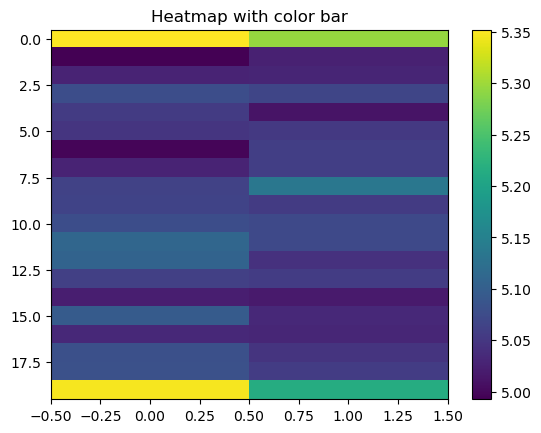

In [45]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_inp_exc_no_adthr_vstdp = np.full((len(pg_inp), len(ng_exc_no_adthr_vstdp)), np.nan)
# Insert the values from the Synapses object
W_inp_exc_no_adthr_vstdp[syns_inp_exc_no_adthr_vstdp_mon.i[:,-1:], syns_inp_exc_no_adthr_vstdp_mon.j[:,-1:]] = syns_inp_exc_no_adthr_vstdp_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
imshow(W_inp_exc_no_adthr_vstdp, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
colorbar() 

show()

In [46]:
print(W_inp_exc_no_adthr_vstdp)

[[5.35208818 5.29496984]
 [4.99262153 5.02583379]
 [5.02883838 5.03032382]
 [5.07812733 5.06742192]
 [5.05467819 5.01120269]
 [5.04874178 5.05201705]
 [4.99726144 5.05886091]
 [5.02837963 5.05941226]
 [5.06311787 5.13482208]
 [5.06440905 5.05440541]
 [5.07737621 5.07239509]
 [5.11181212 5.0722231 ]
 [5.10676726 5.04327127]
 [5.06044326 5.05605346]
 [5.0232827  5.01883544]
 [5.09623583 5.03369041]
 [5.03464822 5.03153938]
 [5.08101365 5.04700731]
 [5.08131648 5.05656608]
 [5.34737983 5.21582111]]


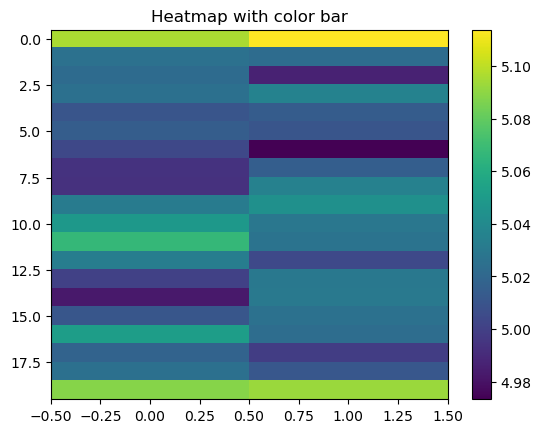

In [47]:
#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
W_inp_exc_adthr_vstdp = np.full((len(pg_inp), len(ng_exc_adthr_vstdp)), np.nan)
# Insert the values from the Synapses object
W_inp_exc_adthr_vstdp[syns_inp_exc_adthr_vstdp_mon.i[:,-1:], syns_inp_exc_adthr_vstdp_mon.j[:,-1:]] = syns_inp_exc_adthr_vstdp_mon.w[:, -1:]

fig, ax = plt.subplots()
ax.set_title("Heatmap with color bar")
extent = -0.5, N_NEURONS-0.5, -0.5, N_INP-0.5
imshow(W_inp_exc_adthr_vstdp, interpolation='none', origin='upper', aspect='auto')
# Add colorbar 
colorbar() 

show()

In [48]:
print(W_inp_exc_adthr_vstdp)

[[5.096125   5.1137893 ]
 [5.02561612 5.02320319]
 [5.02263916 4.98662466]
 [5.02492545 5.03551113]
 [5.01023445 5.01439173]
 [5.01464421 5.0102848 ]
 [5.00395368 4.9733013 ]
 [4.99369085 5.01527725]
 [4.99311978 5.03512005]
 [5.03181975 5.04409017]
 [5.04800845 5.02927028]
 [5.06700063 5.0266702 ]
 [5.03302006 5.00421362]
 [5.00035409 5.02950476]
 [4.98279666 5.03034841]
 [5.01067457 5.02554438]
 [5.05165693 5.02332751]
 [5.01813031 4.99866679]
 [5.02493102 5.01158961]
 [5.08840531 5.09252923]]


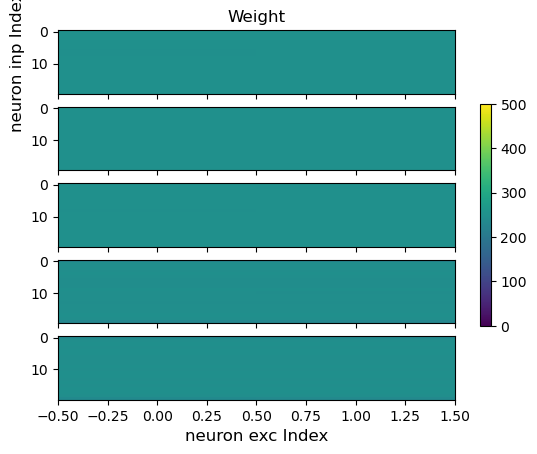

In [291]:
## Reference:
# [1] https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subfigures.html

#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
#W_inp_exc = np.full((len(pg_inp), len(ng_exc)), np.nan)
# Insert the values from the Synapses object
#W_inp_exc[syns_inp_exc_mon.i[:,-1:], syns_inp_exc_mon.j[:,-1:]] = syns_inp_exc_mon.w[:, -1:]

#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
#W_inp_exc_no_adthr = np.full((len(pg_inp), len(ng_exc_no_adthr)), np.nan)
# Insert the values from the Synapses object
#W_inp_exc_no_adthr[syns_inp_exc_no_adthr_mon.i[:,-1:], syns_inp_exc_no_adthr_mon.j[:,-1:]] = syns_inp_exc_no_adthr_mon.w[:, -1:]

#stored_inp_exc.w = syns_inp_exc_mon.w[:, -1]
#W_inp_exc_adthr_sm_nosie = np.full((len(pg_inp), len(ng_exc_sm_noise)), np.nan)
# Insert the values from the Synapses object
#W_inp_exc_adthr_sm_nosie[syns_inp_exc_adthr_sm_noise_mon.i[:,-1:], syns_inp_exc_adthr_sm_noise_mon.j[:,-1:]] = syns_inp_exc_adthr_sm_noise_mon.w[:, -1:]

# must set vmin, vmax, so that the colobar is shared correctly
vmin = 0
vmax = wmax
fontsize=12
fig, axsRight = subplots(5, sharex=True)
pc = axsRight[0].imshow(W_inp_exc, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[0].set_xlabel('neuron exc Index', fontsize=fontsize)
axsRight[0].set_ylabel('neuron inp Index', fontsize=fontsize)
axsRight[0].set_title('Weight', fontsize=fontsize)

pc = axsRight[1].imshow(W_inp_exc_no_adthr, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[1].set_xlabel('neuron exc Index', fontsize=fontsize)
#axsRight[1].set_ylabel('neuron inp Index', fontsize=fontsize)
#axsRight[1].set_title('Title', fontsize=fontsize)

pc = axsRight[2].imshow(W_inp_exc_adthr_sm_nosie, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[2].set_xlabel('neuron exc Index', fontsize=fontsize)


pc = axsRight[3].imshow(W_inp_exc_no_adthr_vstdp, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[3].set_xlabel('neuron exc Index', fontsize=fontsize)

pc = axsRight[4].imshow(W_inp_exc_adthr_vstdp, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
axsRight[4].set_xlabel('neuron exc Index', fontsize=fontsize)


colorbar(pc, shrink=0.6, ax=axsRight)
#suptitle('Weights', fontsize='x-large')
show()

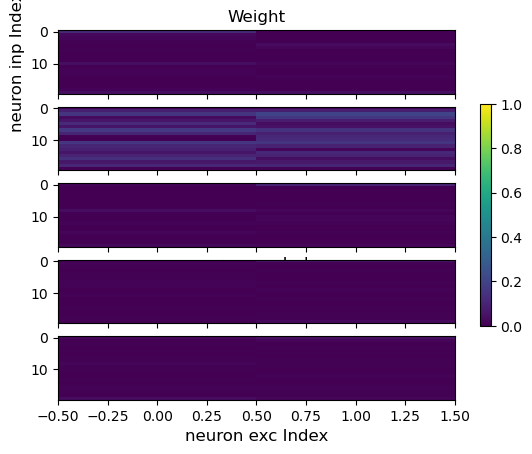

In [620]:
Diff_inp_exc = abs(W_inp_exc - prev_inp_exc)
Diff_inp_exc_no_adthr = abs(W_inp_exc_no_adthr - prev_inp_excc_no_adthr)
Diff_inp_exc_sm_nosie = abs(W_inp_exc_adthr_sm_nosie - prev_inp_exc_adthr_sm_nosie)
Diff_inp_exc_no_adthr_vstdp = abs(W_inp_exc_no_adthr_vstdp - prev_inp_exc_no_adthr_vstdp)
Diff_inp_exc_adthr_vstdp = abs(W_inp_exc_adthr_vstdp - prev_inp_exc_adthr_vstdp)

# must set vmin, vmax, so that the colobar is shared correctly
vmin =  0
vmax = 1
fontsize=12
fig, axsRight = subplots(5, sharex=True)
pc = axsRight[0].imshow(Diff_inp_exc, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[0].set_xlabel('neuron exc Index', fontsize=fontsize)
axsRight[0].set_ylabel('neuron inp Index', fontsize=fontsize)
axsRight[0].set_title('Weight', fontsize=fontsize)

pc = axsRight[1].imshow(Diff_inp_exc_no_adthr, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
#axsRight[1].set_xlabel('neuron exc Index', fontsize=fontsize)
#axsRight[1].set_ylabel('neuron inp Index', fontsize=fontsize)
#axsRight[1].set_title('Title', fontsize=fontsize)

pc = axsRight[2].imshow(Diff_inp_exc_sm_nosie, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
axsRight[2].set_xlabel('neuron exc Index', fontsize=fontsize)
#axsRight[2].set_ylabel('neuron inp Index', fontsize=fontsize)
#axsRight[1].set_title('Title', fontsize=fontsize)

pc = axsRight[3].imshow(Diff_inp_exc_no_adthr_vstdp, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)


pc = axsRight[4].imshow(Diff_inp_exc_adthr_vstdp, interpolation='none', origin='upper', aspect='auto', vmin=vmin, vmax=vmax)
axsRight[4].set_xlabel('neuron exc Index', fontsize=fontsize)


colorbar(pc, shrink=0.6, ax=axsRight)
#suptitle('Weights', fontsize='x-large')
show()


In [621]:
prev_inp_exc = W_inp_exc
prev_inp_excc_no_adthr = W_inp_exc_no_adthr
prev_inp_exc_adthr_sm_nosie = W_inp_exc_adthr_sm_nosie
prev_inp_exc_no_adthr_vstdp = W_inp_exc_no_adthr_vstdp
prev_inp_exc_adthr_vstdp = W_inp_exc_adthr_vstdp

In [622]:
# average of total weight of all the synapses
avr_sum_w = []
avr_sum_w_no_adthr = []
avr_sum_w_adthr_sm_nosie = []
avr_sum_w_no_adthr_vstdp = []
avr_sum_w_adthr_vstdp = []

# average the weight over every 100ms, over number of total synapses
time_interval = 1e4 *ms
num_w = int(time_interval / defaultclock.dt)

#window = np.arange(100000 * ms, 200000 * ms, defaultclock.dt) / ms
time_window = 6.5e5* ms
for i in range(int(time_window/time_interval)): # range(2): # range(int(1/1e-3)):
#for i in window: # range(2): # range(int(1/1e-3)):
    avr_over_time = np.average(syns_inp_exc_mon.w[:, int(i*num_w):int((i+1)*num_w -1)], axis=1,  keepdims=True)
    avr_over_time_no_adthr = np.average(syns_inp_exc_no_adthr_mon.w[:, int(i*num_w):int((i+1)*num_w -1)], axis=1,  keepdims=True)
    avr_over_time_adthr_sm_nosie = np.average(syns_inp_exc_adthr_sm_noise_mon.w[:, int(i*num_w):int((i+1)*num_w -1)], axis=1,  keepdims=True)
    avr_over_time_no_adthr_vstdp = np.average(syns_inp_exc_no_adthr_vstdp_mon.w[:, int(i*num_w):int((i+1)*num_w -1)], axis=1,  keepdims=True)
    avr_over_time_adthr_vstdp = np.average(syns_inp_exc_adthr_vstdp_mon.w[:, int(i*num_w):int((i+1)*num_w -1)], axis=1,  keepdims=True)
    #print(shape(avr_over_time))
    avr_over_synap = np.average(avr_over_time, axis=0,  keepdims=True)
    avr_over_synap_no_adthr = np.average(avr_over_time_no_adthr, axis=0,  keepdims=True)
    avr_over_synap_adthr_sm_nosie = np.average(avr_over_time_adthr_sm_nosie, axis=0,  keepdims=True)
    avr_over_synap_no_adthr_vstdp = np.average(avr_over_time_no_adthr_vstdp, axis=0,  keepdims=True)
    avr_over_synap_adthr_vstdp = np.average(avr_over_time_adthr_vstdp, axis=0,  keepdims=True)
    #print(shape(avr_over_synap))
    # flattened
    avr_over_synap = np.reshape(avr_over_synap, (-1))
    avr_over_synap_no_adthr = np.reshape(avr_over_synap_no_adthr, (-1))
    avr_over_synap_adthr_sm_nosie = np.reshape(avr_over_synap_adthr_sm_nosie, (-1))
    avr_over_synap_no_adthr_vstdp = np.reshape(avr_over_synap_no_adthr_vstdp, (-1))
    avr_over_synap_adthr_vstdp = np.reshape(avr_over_synap_adthr_vstdp, (-1))
    #print(shape(avr_over_synap))
    avr_sum_w.append(avr_over_synap)
    avr_sum_w_no_adthr.append(avr_over_synap_no_adthr)
    avr_sum_w_adthr_sm_nosie.append(avr_over_synap_adthr_sm_nosie)
    avr_sum_w_no_adthr_vstdp.append(avr_over_synap_no_adthr_vstdp)
    avr_sum_w_adthr_vstdp.append(avr_over_synap_adthr_vstdp)


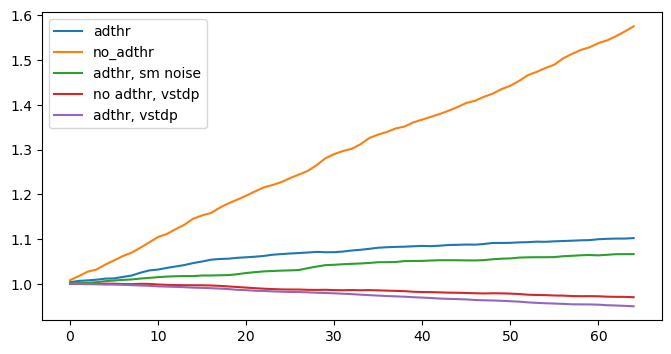

In [623]:
figure(figsize=(8, 4))
plot(np.arange(len(avr_sum_w)), avr_sum_w, label = 'adthr')
plot(np.arange(len(avr_sum_w_no_adthr)), avr_sum_w_no_adthr, label = 'no_adthr')
plot(np.arange(len(avr_sum_w_adthr_sm_nosie)), avr_sum_w_adthr_sm_nosie, label = 'adthr, sm noise')
plot(np.arange(len(avr_sum_w_no_adthr_vstdp)), avr_sum_w_no_adthr_vstdp, label = 'no adthr, vstdp')
plot(np.arange(len(avr_sum_w_adthr_vstdp)), avr_sum_w_adthr_vstdp, label = 'adthr, vstdp')
legend()
show()

## Save and Load

### Save

In [637]:
def save_npy(arr, path):
    arr = np.array(arr)
    print('%-9s %-15s => %-30s' % ('Saving', arr.shape, path))
    np.save(path, arr)

In [638]:
from pathlib import Path

In [639]:
Path.cwd()

WindowsPath('C:/Users/20245580/JupyterNotebookFiles')

In [640]:
DATA_PATH = Path('data/Exp2_DepStdp_AdapThres_2outputs/VStdp_include')

In [980]:
print(shape(syns_inp_exc_mon.w))

(40, 3240000)


In [981]:
all_w_over_trials_saved = syns_inp_exc_mon.w
print(shape(all_w_over_trials_saved))

(40, 3240000)


In [982]:
print(shape(net['exc'].theta), net['exc'].theta)

(2,) <exc.theta: array([0.01583984, 0.01605909])>


In [641]:
#athr, 
save_npy(net['inp_exc'].apre, DATA_PATH / 'apre_adthr.npy')
save_npy(net['inp_exc'].apost, DATA_PATH / 'apost_adthr.npy')
save_npy(syns_inp_exc_mon.w, DATA_PATH / 'all_w_adthr.npy')
save_npy(net['exc'].theta, DATA_PATH / 'theta_adthr.npy')
save_npy(net['exc'].ge, DATA_PATH / 'ge_adthr.npy')
save_npy(net['exc'].gi, DATA_PATH / 'gi_adthr.npy')
save_npy(net['exc'].v, DATA_PATH / 'v_adthr.npy')

#no adthr
save_npy(net['inp_exc_no_adthr'].apre, DATA_PATH / 'apre_no_adthr.npy')
save_npy(net['inp_exc_no_adthr'].apost, DATA_PATH / 'apost_no_adthr.npy')
save_npy(syns_inp_exc_no_adthr_mon.w, DATA_PATH / 'all_w_no_adthr.npy')
save_npy(net['exc_no_adthr'].theta, DATA_PATH / 'theta_no_adthr.npy')
save_npy(net['exc_no_adthr'].ge, DATA_PATH / 'ge_no_adthr.npy')
save_npy(net['exc_no_adthr'].gi, DATA_PATH / 'gi_no_adthr.npy')
save_npy(net['exc_no_adthr'].v, DATA_PATH / 'v_no_adthr.npy')

# adthr, small noise
save_npy(net['inp_exc_no_adthr_sm_nosie'].apre, DATA_PATH / 'apre_no_adthr_sm_nosie.npy')
save_npy(net['inp_exc_no_adthr_sm_nosie'].apost, DATA_PATH / 'apost_no_adthr_sm_nosie.npy')
save_npy(syns_inp_exc_adthr_sm_noise_mon.w, DATA_PATH / 'all_w_no_adthr_sm_nosie.npy')
save_npy(net['exc_sm_noise'].theta, DATA_PATH / 'theta_no_adthr_sm_nosie.npy')
save_npy(net['exc_sm_noise'].ge, DATA_PATH / 'ge_no_adthr_sm_nosie.npy')
save_npy(net['exc_sm_noise'].gi, DATA_PATH / 'gi_no_adthr_sm_nosie.npy')
save_npy(net['exc_sm_noise'].v, DATA_PATH / 'v_no_adthr_sm_nosie.npy')


# no adthr, vstdp
save_npy(net['inp_exc_no_adthr_vstdp'].x_trace_prespike, DATA_PATH / 'x_trace_no_adthr_vstdp.npy')
save_npy(syns_inp_exc_no_adthr_vstdp.w, DATA_PATH / 'all_w_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].theta, DATA_PATH / 'theta_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].ge, DATA_PATH / 'ge_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].gi, DATA_PATH / 'gi_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].v, DATA_PATH / 'v_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].v_lowpass1, DATA_PATH / 'v_lowpass1_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].v_lowpass2, DATA_PATH / 'v_lowpass2_no_adthr_vstdp.npy')
save_npy(net['exc_no_adthr_vstdp'].v_homeo, DATA_PATH / 'v_homeo_no_adthr_vstdp.npy')


# adthr, vstdp
save_npy(net['inp_exc_adthr_vstdp'].x_trace_prespike, DATA_PATH / 'x_trace_adthr_vstdp.npy')
save_npy(syns_inp_exc_adthr_vstdp.w, DATA_PATH / 'all_w_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].theta, DATA_PATH / 'theta_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].ge, DATA_PATH / 'ge_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].gi, DATA_PATH / 'gi_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].v, DATA_PATH / 'v_no_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].v_lowpass1, DATA_PATH / 'v_lowpass1_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].v_lowpass2, DATA_PATH / 'v_lowpass2_adthr_vstdp.npy')
save_npy(net['exc_adthr_vstdp'].v_homeo, DATA_PATH / 'v_homeo_adthr_vstdp.npy')

Saving    (40,)           => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\apre_adthr.npy
Saving    (40,)           => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\apost_adthr.npy
Saving    (40, 1320000)   => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\all_w_adthr.npy
Saving    (2,)            => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\theta_adthr.npy
Saving    (2,)            => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\ge_adthr.npy
Saving    (2,)            => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\gi_adthr.npy
Saving    (2,)            => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\v_adthr.npy
Saving    (40,)           => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\apre_no_adthr.npy
Saving    (40,)           => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\apost_no_adthr.npy
Saving    (40, 1320000)   => data\Exp2_DepStdp_AdapThres_2outputs\VStdp_include\all_w_no_adthr.npy
Saving    (2,)            => data\Exp2_DepS

### Load

In [1439]:
def load_npy(path):
    arr = np.load(path)
    print('%-9s %-30s => %-15s' % ('Loading', path, arr.shape))
    return arr

In [24]:
a = 2*mV
print(a, a/mV) 

2. mV 2.0
